# 1. Import Libraries and Set up Dependencies

In [0]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import missingno.missingno as ms
import datetime
import gc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

# 2. Obtain Data

In [0]:
if not os.path.isfile('./train.csv') and not os.path.isfile('./test.csv'):
  # Install Kaggle API for download competition data
  !pip3 install -q kaggle
  # enter your Kaggle credentionals here
  os.environ['KAGGLE_USERNAME']="shancho"
  os.environ['KAGGLE_KEY']="761769e99826fd2d29a4f57bc76fbeb4"

  # If you are unable to download the competition dataset, check to see if you have 
  # accepted the user agreement on the competition website. 
  !kaggle competitions download -c elo-merchant-category-recommendation

In [3]:
!ls -l

total 3644680
-rw-r--r-- 1 root root      17600 May 25 16:29 Data_Dictionary.xlsx
---------- 1 root root 2845920484 Nov 23  2018 historical_transactions.csv
-rw-r--r-- 1 root root  564605581 May 25 16:29 historical_transactions.csv.zip
---------- 1 root root   50040976 Nov 23  2018 merchants.csv
-rw-r--r-- 1 root root   12817526 May 25 16:29 merchants.csv.zip
---------- 1 root root  190246145 Nov 23  2018 new_merchant_transactions.csv
-rw-r--r-- 1 root root   51292036 May 25 16:29 new_merchant_transactions.csv.zip
drwxr-xr-x 1 root root       4096 May 22 16:22 sample_data
-rw-r--r-- 1 root root     858459 May 25 16:29 sample_submission.csv.zip
---------- 1 root root    3708740 Nov 23  2018 test.csv
-rw-r--r-- 1 root root    1146203 May 25 16:29 test.csv.zip
---------- 1 root root    8383651 Nov 23  2018 train.csv
-rw-r--r-- 1 root root    3076675 May 25 16:29 train.csv.zip


In [4]:
!unzip test.csv.zip 
!unzip train.csv.zip
!unzip historical_transactions.csv.zip
!unzip merchants.csv.zip
!unzip new_merchant_transactions.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: test.csv                
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: train.csv               
Archive:  historical_transactions.csv.zip
replace historical_transactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: historical_transactions.csv  
Archive:  merchants.csv.zip
replace merchants.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: merchants.csv           
Archive:  new_merchant_transactions.csv.zip
replace new_merchant_transactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: new_merchant_transactions.csv  
Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: test.csv                
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: train.csv               


In [6]:
ls -l

total 3644680
-rw-r--r-- 1 root root      17600 May 25 16:29 Data_Dictionary.xlsx
---------- 1 root root 2845920484 Nov 23  2018 historical_transactions.csv
-rw-r--r-- 1 root root  564605581 May 25 16:29 historical_transactions.csv.zip
---------- 1 root root   50040976 Nov 23  2018 merchants.csv
-rw-r--r-- 1 root root   12817526 May 25 16:29 merchants.csv.zip
---------- 1 root root  190246145 Nov 23  2018 new_merchant_transactions.csv
-rw-r--r-- 1 root root   51292036 May 25 16:29 new_merchant_transactions.csv.zip
drwxr-xr-x 1 root root       4096 May 22 16:22 sample_data/
-rw-r--r-- 1 root root     858459 May 25 16:29 sample_submission.csv.zip
---------- 1 root root    3708740 Nov 23  2018 test.csv
-rw-r--r-- 1 root root    1146203 May 25 16:29 test.csv.zip
---------- 1 root root    8383651 Nov 23  2018 train.csv
-rw-r--r-- 1 root root    3076675 May 25 16:29 train.csv.zip


In [0]:

!chmod 777 *.csv #make the file readable, writable and executable by everyone/ assigning permissions

In [0]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_hist_trans = pd.read_csv('historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('new_merchant_transactions.csv')

# Reduce Memory 

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
#Reducing the memory usage for historical_Transaction and new_merchant_transaction data.
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_merchant_trans = reduce_mem_usage(df_new_merchant_trans)

Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


# Data Exploring

In [11]:
df_hist_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int16
category_1              object
installments            int16
category_3              object
merchant_category_id    int16
merchant_id             object
month_lag               int8
purchase_amount         float32
purchase_date           object
category_2              float16
state_id                int8
subsector_id            int8
dtypes: float16(1), float32(1), int16(3), int8(3), object(6)
memory usage: 1.7+ GB


In [12]:
df_hist_trans.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id
count,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,2.911236e+07,26459497.0,2.911236e+07,2.911236e+07
mean,1.293256e+02,6.484954e-01,4.810130e+02,-4.487294e+00,6.134567e-02,NaN,1.056679e+01,2.684839e+01
std,1.042563e+02,2.795577e+00,2.493757e+02,3.588800e+00,1.123521e+03,0.0,6.366927e+00,9.692793e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.300000e+01,-7.469078e-01,1.0,-1.000000e+00,-1.000000e+00
25%,5.300000e+01,0.000000e+00,3.070000e+02,-7.000000e+00,-7.203559e-01,1.0,9.000000e+00,1.900000e+01
50%,9.000000e+01,0.000000e+00,4.540000e+02,-4.000000e+00,-6.883495e-01,1.0,9.000000e+00,2.900000e+01
75%,2.120000e+02,1.000000e+00,7.050000e+02,-2.000000e+00,-6.032543e-01,3.0,1.600000e+01,3.400000e+01
max,3.470000e+02,9.990000e+02,8.910000e+02,0.000000e+00,6.010604e+06,5.0,2.400000e+01,4.100000e+01


In [0]:
ms.matrix(df_hist_trans)

In [0]:
df_new_merchant_trans.info()

In [0]:
df_new_merchant_trans.describe()

In [0]:
ms.matrix(df_new_merchant_trans)

# Data Preprocessing

In [0]:
# Imputing the Nan's with mode.
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [0]:
# Userdefined function to do aggregation on features  to extract new features.
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [0]:
# loyalty points will be assigned only after 2 months of card usage .
# This is not give in the data so to get that we are extacting year,month,day,time and they start using the card.
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [16]:
# doingn the aggregation on extracted columns.
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

42

In [17]:
# Repeating the same operation on new_merchants_transaction data.
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [0]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,-0.550293,-0.592773,54.0,2.347826,241.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,-0.550293,-0.606445,56.0,9.333333,271.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,-0.548828,-0.592773,0.0,0.000000,242.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,-0.556641,-0.604492,41.0,5.857143,252.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,-0.555664,-0.588379,57.0,1.583333,242.0


# Handling Outliers

In [18]:
# Target has outliers so creating a new column-outliers,to impute with mean of the fearure's group it belongs to.
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [0]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [0]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

# Set parameters and Training with StratifiedKFold
Evalutation with Root Mean Square Error RMSE

In [21]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66307	valid_1's rmse: 3.73405
[200]	training's rmse: 3.58521	valid_1's rmse: 3.7025
[300]	training's rmse: 3.5376	valid_1's rmse: 3.69093
[400]	training's rmse: 3.50168	valid_1's rmse: 3.68349
[500]	training's rmse: 3.47117	valid_1's rmse: 3.67842
[600]	training's rmse: 3.44497	valid_1's rmse: 3.6755
[700]	training's rmse: 3.4229	valid_1's rmse: 3.67365
[800]	training's rmse: 3.40259	valid_1's rmse: 3.67204
[900]	training's rmse: 3.38427	valid_1's rmse: 3.67115
[1000]	training's rmse: 3.36697	valid_1's rmse: 3.67054
[1100]	training's rmse: 3.34974	valid_1's rmse: 3.66987
[1200]	training's rmse: 3.33415	valid_1's rmse: 3.67001
Early stopping, best iteration is:
[1107]	training's rmse: 3.34881	valid_1's rmse: 3.66982
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67243	valid_1's rmse: 3.70273
[200]	training's rmse: 3.59697	valid_1's rmse: 3.66817


3.655782166184337

# Plotting Feature Importance 

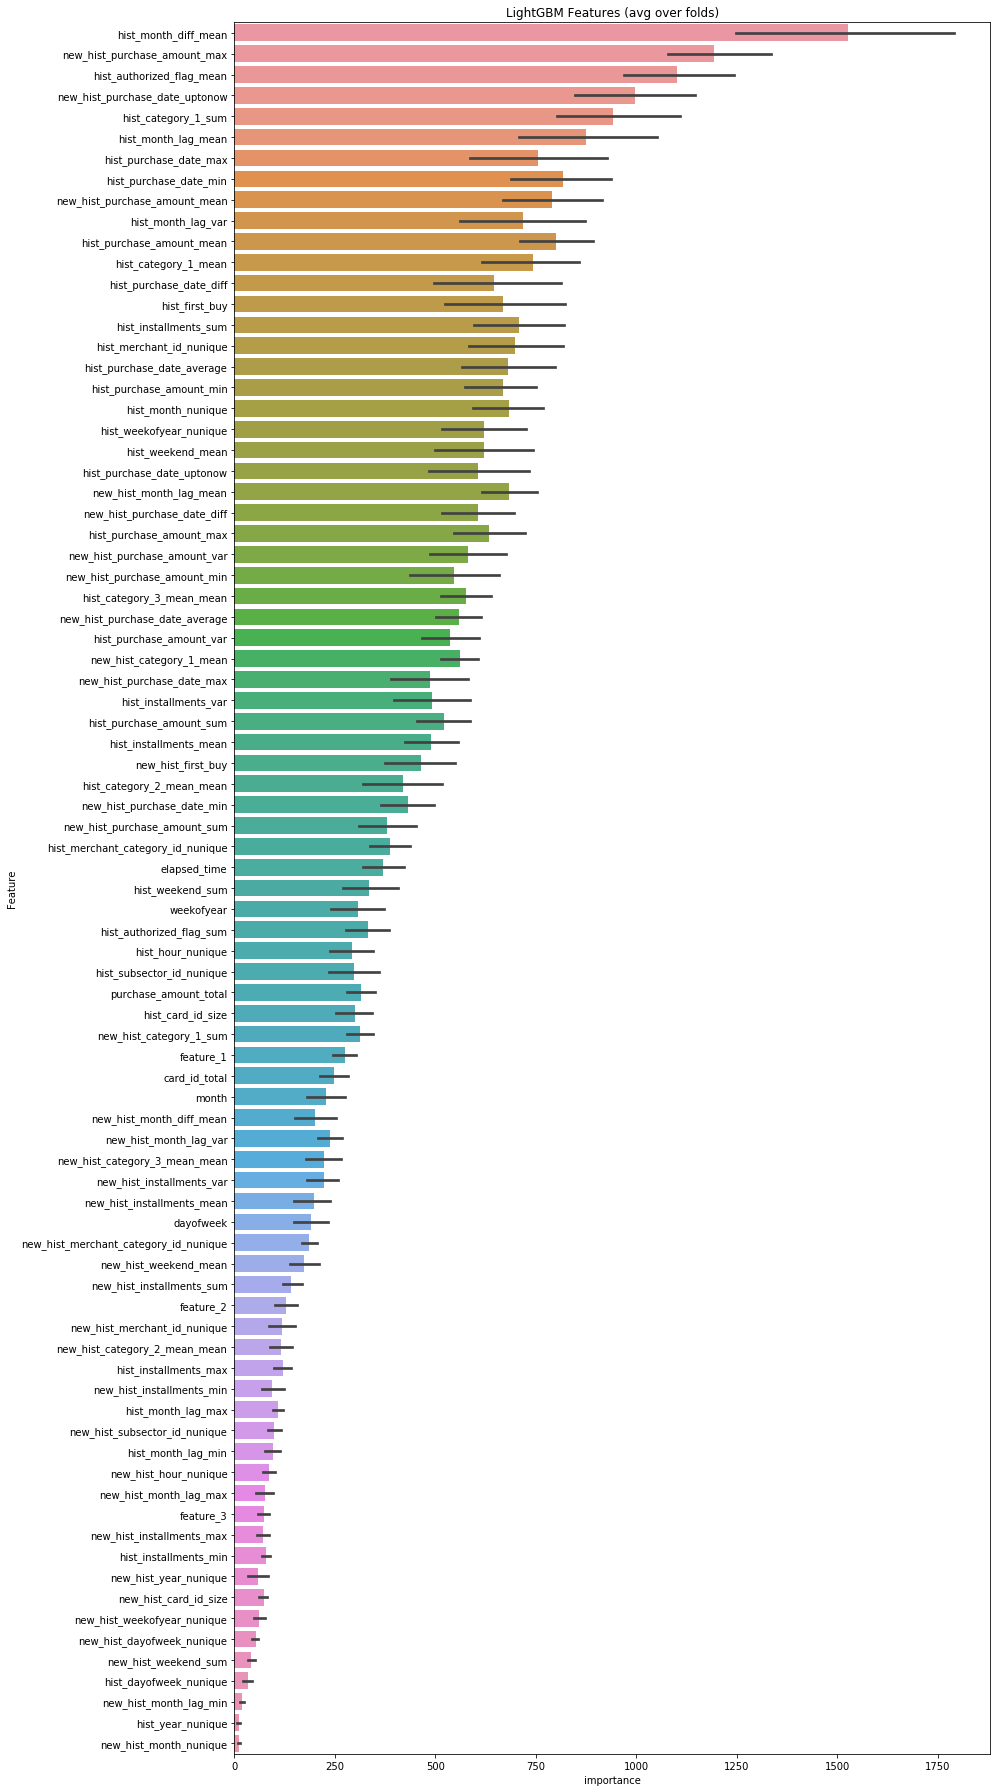

In [22]:
#Plotting the feature importance.
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# Submission

In [0]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

In [0]:
from google.colab import files
files.download('submission.csv')

# Testing with  CATBoost Algorithm 


In [23]:
!pip3 install catboost

     |████████████████████████████████| 60.6MB 562kB/s 


In [0]:
from sklearn.model_selection import KFold

In [30]:
 %%time
 from catboost import CatBoostRegressor
 folds = KFold(n_splits=5, shuffle=True, random_state=15)
 oof_cat = np.zeros(len(df_train))
 predictions_cat = np.zeros(len(df_test))

 for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
     print("fold n°{}".format(fold_ + 1))
     trn_data, trn_y = df_train.iloc[trn_idx][df_train_columns], target.iloc[trn_idx].values
     val_data, val_y = df_train.iloc[val_idx][df_train_columns], target.iloc[val_idx].values
     print("-" * 10 + "Catboost " + str(fold_) + "-" * 10)
     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=100)
    
     oof_cat[val_idx] = cb_model.predict(val_data)
     predictions_cat += cb_model.predict(df_test[df_train_columns]) / folds.n_splits
    
 np.save('oof_cat', oof_cat)
 np.save('predictions_cat', predictions_cat)
 np.sqrt(mean_squared_error(target.values, oof_cat))
 gc.collect()

fold n°1
----------Catboost 0----------


0:	learn: 3.8353631	test: 3.8789514	best: 3.8789514 (0)	total: 137ms	remaining: 6m 50s
100:	learn: 3.5909259	test: 3.6785308	best: 3.6785308 (100)	total: 12.6s	remaining: 6m 1s
200:	learn: 3.5197276	test: 3.6724232	best: 3.6720368 (187)	total: 24.6s	remaining: 5m 43s
Stopped by overfitting detector  (45 iterations wait)

bestTest = 3.670501996
bestIteration = 244

Shrink model to first 245 iterations.
fold n°2
----------Catboost 1----------


0:	learn: 3.8559300	test: 3.8008769	best: 3.8008769 (0)	total: 133ms	remaining: 6m 38s
100:	learn: 3.5943912	test: 3.6203142	best: 3.6203010 (99)	total: 13.7s	remaining: 6m 32s
200:	learn: 3.5288360	test: 3.6171360	best: 3.6166456 (182)	total: 26.2s	remaining: 6m 5s
Stopped by overfitting detector  (45 iterations wait)

bestTest = 3.616645576
bestIteration = 182

Shrink model to first 183 iterations.
fold n°3
----------Catboost 2----------


0:	learn: 3.8596301	test: 3.7706188	best: 3.7706188 (0)	total: 136ms	remaining: 6m 48s
100:	learn: 3.6063581	test: 3.5979129	best: 3.5978757 (98)	total: 12.9s	remaining: 6m 11s
200:	learn: 3.5501840	test: 3.5940319	best: 3.5938719 (198)	total: 24.4s	remaining: 5m 40s
Stopped by overfitting detector  (45 iterations wait)

bestTest = 3.593166342
bestIteration = 244

Shrink model to first 245 iterations.
fold n°4
----------Catboost 3----------


0:	learn: 3.8073378	test: 3.9812448	best: 3.9812448 (0)	total: 136ms	remaining: 6m 48s
100:	learn: 3.5675081	test: 3.8002883	best: 3.8002883 (100)	total: 12.4s	remaining: 5m 55s
200:	learn: 3.4981300	test: 3.7923494	best: 3.7923321 (198)	total: 25.6s	remaining: 5m 55s
Stopped by overfitting detector  (45 iterations wait)

bestTest = 3.791162927
bestIteration = 254

Shrink model to first 255 iterations.
fold n°5
----------Catboost 4----------


0:	learn: 3.8567180	test: 3.7848430	best: 3.7848430 (0)	total: 154ms	remaining: 7m 41s
100:	learn: 3.6066855	test: 3.6228897	best: 3.6227365 (98)	total: 13.7s	remaining: 6m 33s
200:	learn: 3.5472157	test: 3.6222677	best: 3.6213406 (183)	total: 25.3s	remaining: 5m 51s
Stopped by overfitting detector  (45 iterations wait)

bestTest = 3.620896376
bestIteration = 223

Shrink model to first 224 iterations.
CPU times: user 5min 49s, sys: 9.08 s, total: 5min 58s
Wall time: 3min 16s


# Testing with XGBoost 

In [0]:
from sklearn.model_selection import RepeatedKFold

In [41]:
%%time

import xgboost as xgb

xgb_params = {'eta': 0.005, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'alpha':0.1,
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'random_state':folds}


folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)
oof_xgb = np.zeros(len(df_train))
predictions_xgb = np.zeros(len(df_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print("fold n°{}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 11000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(df_train.iloc[val_idx][df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(df_test[df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50) / 10
    
np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
print("RMSE : ",np.sqrt(mean_squared_error(target.values, oof_xgb)))
gc.collect()

fold n°1
xgb 0--------------------------------------------------
[0]	train-rmse:3.9481	valid-rmse:3.96175
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	train-rmse:3.67247	valid-rmse:3.70309
[2000]	train-rmse:3.6441	valid-rmse:3.69082
[3000]	train-rmse:3.62519	valid-rmse:3.68494


KeyboardInterrupt: ignored